In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import clr, multiplicative_replacement

In [47]:
def prevalent_genes(data: pd.DataFrame) -> list[str]:
    """
    Calculate the prevalence of a gene across samples.
    :param data: pd.DataFrame of gene expression data
    :return: pd.DataFrame of gene expression data post filtering
    """
    prevalence = data.astype(bool).sum(axis=1) / data.shape[1]
    prevalence = prevalence[prevalence > 0.05]
    return list(set(prevalence.index))

def number_of_genes_per_sample(data: pd.DataFrame) -> list[str]:
    """
    Calculate the number of genes expressed in each sample.
    :param data: pd.DataFrame of gene expression data
    :return: pd.DataFrame of gene expression data post filtering
    """
    prevalence = data.astype(bool).sum(axis=0)
    prevalence = prevalence[prevalence > 200]
    return list(set(prevalence.index))

In [10]:
df = pd.read_csv('/Users/anmolgorakshakar/Downloads/gene_tpm_2017-06-05_v8_lung.gct', sep='\t', skiprows=2)
# remove unnecessary columns.
# id is a irrelevant integer and Name is the Entrez ID.
# Entrez ID can be useful in cross sample set analysis but for this example we will not use it.
columns = [i for i in df.columns if i not in ('id', 'Name')]
df = df[columns]  # retain only filtered columns

In [13]:
df.set_index('Description', inplace=True)  #  set index to gene_symbol
df.rename_axis('gene_symbol', inplace=True)  # rename index to gene_symbol. This is more descriptive than "Description"

In [48]:
df = df.loc[(df != 0).any(axis=1)]  # remove rows with all zeros. These are artifacts of sequencing data merged with reference gene lists
df = df.loc[prevalent_genes(df)]  # remove genes that are not expressed in at least 5% of samples
df = df[number_of_genes_per_sample(df)]  # remove samples with less than 200 genes expressed

In [50]:
mr_np = multiplicative_replacement(df.values)  # multiplicative replacement of zeros
clr_np = clr(mr_np)  # center log ratio transformation
df_clr_np = pd.DataFrame(clr_np,
                  columns=df.columns,
                  index=df.index)

## Visualization

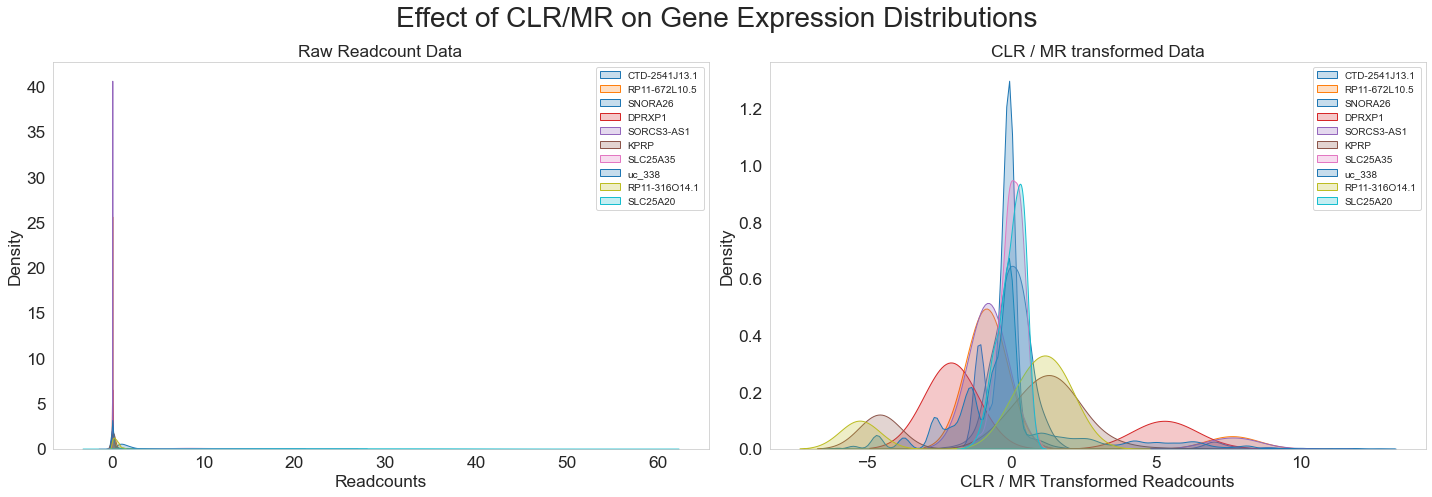

In [51]:
GENES = list(df_clr_np.sample(10).index)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
for gene in GENES:

    X2 = df.loc[gene][[i for i in df if i not in ('id', 'Name', 'Description')]].T
    sns.kdeplot(X2, fill=True, ax=ax1)
    ax1.set_title('Raw Readcount Data', size='xx-large')


    X1 = df_clr_np.loc[gene][[i for i in df if i not in ('id', 'Name', 'Description')]].T
    sns.kdeplot(X1, fill=True, ax=ax2)
    ax2.set_title('CLR / MR transformed Data', size='xx-large')

for a in [ax1, ax2]:
    if a == ax1:
        a.set_xlabel('Readcounts', size='xx-large')
    if a == ax2:
        a.set_xlabel('CLR / MR Transformed Readcounts', size='xx-large')
    a.set_ylabel('Density', size='xx-large')
    a.tick_params(labelsize='xx-large')
    a.grid(False)
    a.legend(GENES)

f.suptitle('Effect of CLR/MR on Gene Expression Distributions', size='xx-large', fontsize=28)
plt.tight_layout()
plt.savefig('/Users/anmolgorakshakar/python/github/binder_project/output_images/clr_mr.png', dpi=500)
plt.show();